In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers
import matplotlib.pyplot as plt

In [2]:
(x_train, y_test), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


$\text{variance} = \sigma^2$,
and $\text{log}(\text{variance}) = \text{log}(\sigma^2) = 2 \text{log}(\sigma)$.

Therefore,
$\sigma = \text{exp}(0.5 \text{log}(\text{variance})) = \text{exp}(0.5 \cdot z\_log\_var)$.

In [3]:
# Create the sampling layer, this helps reresent the data into the sampling space
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(43)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [23]:
def encoder(latent_dim):

  encoder_inputs = keras.Input(shape=(28, 28, 1))
  x = layers.Conv2D(32, 3, activation="leaky_relu", strides=2, padding="same")(encoder_inputs)
  x = layers.Conv2D(64, 3, activation="leaky_relu", strides=2, padding="same")(x)
  x = layers.Flatten()(x)
  x = layers.Dense(16, activation="relu")(x)
  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])
  encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
  return encoder



In [22]:
def decoder(latent_dim):
  latent_inputs = keras.Input(shape=(latent_dim,))
  x = layers.Dense(7 * 7 * 64, activation="leaky_relu")(latent_inputs)
  x = layers.Reshape((7, 7, 64))(x)
  x = layers.Conv2DTranspose(64, 3, activation="leaky_relu", strides=2, padding="same")(x)
  x = layers.Conv2DTranspose(32, 3, activation="leaky_relu", strides=2, padding="same")(x)
  decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
  return keras.Model(latent_inputs, decoder_outputs, name="decoder")


Define el VAE as a child model. A custom train_step function is created. this allows the VAE

In [34]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            keras.metrics.Mean(name="loss"),
            keras.metrics.Mean(name="reconstruction_loss"),
            keras.metrics.Mean(name="kl_loss"),
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
          z_mean, z_log_var, z = self.encoder(data)
          reconstruction = self.decoder(z)
          reconstruction_loss = ops.mean(
              ops.sum(
                  keras.losses.binary_crossentropy(data, reconstruction),
                  axis=(1, 2),
              )
          )
          kl_loss = -0.5 * ( 1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
          kl_loss = ops.sum(kl_loss, axis=1)
          total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        _, _, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

In [29]:
latent_dim = 10
enc = encoder(latent_dim)
dec = decoder(latent_dim)

enc.summary()
dec.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 3136)      │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │     50,192 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 10)        │        170 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 10)        │        170 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 10)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,348 (270.89 KB)

 Trainable params: 69,348 (270.89 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3136)           │        34,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,177 (352.25 KB)

 Trainable params: 90,177 (352.25 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(enc, dec)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - kl_loss: 8.1500 - loss: 140.2331 - reconstruction_loss: 132.0830
Epoch 2/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 8.1477 - loss: 140.2465 - reconstruction_loss: 132.0970
Epoch 3/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 8.1544 - loss: 140.1335 - reconstruction_loss: 131.9779
Epoch 4/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - kl_loss: 8.1596 - loss: 140.0891 - reconstruction_loss: 131.9283
Epoch 5/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - kl_loss: 8.1647 - loss: 140.0479 - reconstruction_loss: 131.8826
Epoch 6/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - kl_loss: 8.1682 - loss: 139.9946 - reconstruction_loss: 131.8258
Epoch 7/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - kl_loss: 8.1731 - loss: 139.9363 - reconstruction_loss: 131.7625
Epoch 8/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 8.1778 - loss: 139.8906 - reconstruction_loss: 131.7122
Epoch 9/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms

In [41]:
def plot_latent_dimension(vae, latent_dim_index, n=10, figsize=10):
    digit_size = 28
    scale = 5.0
    figure = np.zeros((digit_size, digit_size * n))

    print("figure shape:", figure.shape)

    lantent_values = np.linspace(start=-scale, stop=scale, num=n)

    for i, lv in enumerate(lantent_values):
        z_sample = np.zeros((1,10))
        z_sample[0,latent_dim_index] = lv

        x_decoded = vae.decoder.predict(z_sample, verbose=0)
        digit = x_decoded[0].reshape(digit_size, digit_size)

        # Create the plot
        figure[:, i * digit_size : (i + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap="Greys_r")
    plt.xlabel(f"Latent Dimension {latent_dim_index}")
    plt.title(f"Varying Latent Dimension {latent_dim_index}")
    plt.axis("off")
    plt.show()

figure shape: (28, 308)


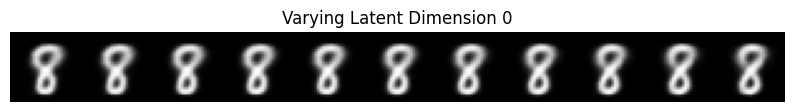

figure shape: (28, 308)


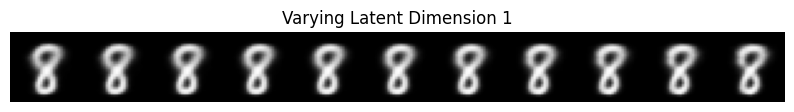

figure shape: (28, 308)


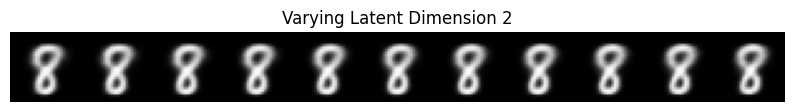

figure shape: (28, 308)


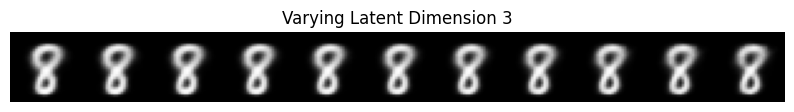

figure shape: (28, 308)


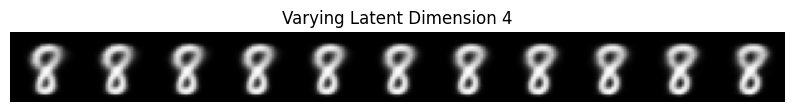

figure shape: (28, 308)


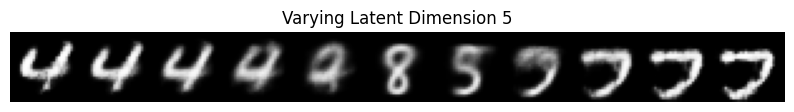

figure shape: (28, 308)


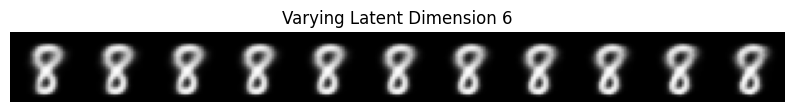

figure shape: (28, 308)


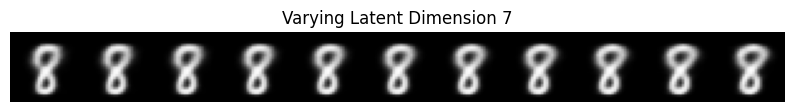

figure shape: (28, 308)


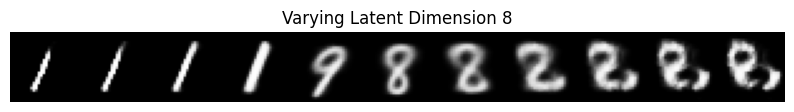

figure shape: (28, 308)


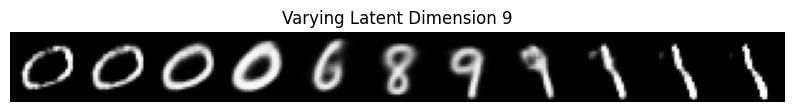

In [43]:
for i in range(10):
  plot_latent_dimension(vae, i, 11)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


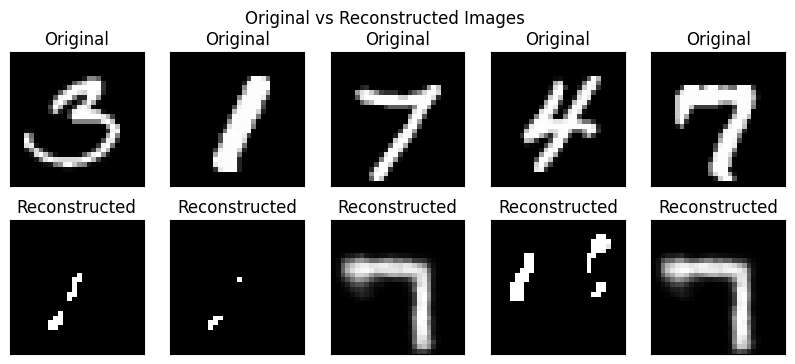

In [36]:
n = 5
random_indices = np.random.choice(len(x_test), n, replace=False)
sample_images = x_test[random_indices]
reconstructed_images = vae.predict(sample_images)

plt.figure(figsize=(10, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(np.squeeze(sample_images[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Original")

    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(np.squeeze(reconstructed_images[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Reconstructed")
plt.suptitle("Original vs Reconstructed Images")
plt.show()

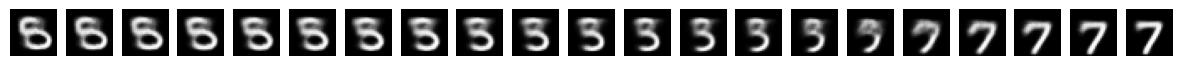

In [38]:
def interpolate_images(vae, image1, image2, n_steps=20):
    # Ensure images have the correct shape and data type
    image1 = np.expand_dims(image1, axis=0).astype("float32") / 255
    image2 = np.expand_dims(image2, axis=0).astype("float32") / 255

    # Encode the images to get their latent representations
    z_mean1, z_log_var1, z1 = vae.encoder.predict(image1, verbose=0)
    z_mean2, z_log_var2, z2 = vae.encoder.predict(image2, verbose=0)

    # We'll interpolate between the z_mean vectors
    interpolated_z = []
    for i in range(n_steps + 1):
        alpha = i / n_steps
        # Linear interpolation in the latent space
        z_interp = z_mean1 * (1 - alpha) + z_mean2 * alpha
        interpolated_z.append(z_interp)

    # Decode the interpolated latent vectors
    transition_images = []
    for z in interpolated_z:
        decoded_image = vae.decoder.predict(z, verbose=0)
        transition_images.append(decoded_image[0].reshape(28, 28)) # Reshape to original image size

    return transition_images

def plot_transition(images, figsize=(15, 3)):
    """Plots a sequence of images."""
    plt.figure(figsize=figsize)
    n_images = len(images)
    for i, img in enumerate(images):
        plt.subplot(1, n_images, i + 1)
        plt.imshow(img, cmap="Greys_r")
        plt.axis("off")
    plt.show()

digit4_index = np.where(y_test == 3)[0][0]
digit7_index = np.where(y_test == 7)[0][0]

digit4 = x_test[digit4_index]
digit7 = x_test[digit7_index]

transition_images = interpolate_images(vae, digit4, digit7)
plot_transition(transition_images)